# TensorFlow roBERTa - Unsupervised Text Selection
Wow, this notebook does not use `selected_text`. This notebook only uses the columns `text` and `sentiment`. We train a roBERTa model to predict sentiment (pos, neg, neu) from Tweet `text` achieving 80% accuracy. We then display what part of the text was influencial in deciding whether the text was postive, negative, or neutral. This is **unsupervised** learning because we are learning the `selected_text` without using the `selected_text`.

This unsupervised DL notebook is inspired by Nick's awesome unsupervised ML notebook [here][1] and it's similar to my previous unsupervised DL notebook for image recognition [here][2]

[1]: https://www.kaggle.com/nkoprowicz/a-simple-solution-using-only-word-counts
[2]: https://www.kaggle.com/cdeotte/unsupervised-masks-cv-0-60

# Load Data

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from transformers import *
import tokenizers
from IPython.core.display import display, HTML
print('TensorFlow',tf.__version__)

TensorFlow 2.1.0


In [2]:
train = pd.read_csv('../input/tweet-sentiment-extraction/train.csv').fillna('')
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


# roBERTa Tokenization
In this section, we create a variety of roBERTa inputs and targets. In this notebook, we only need tokenized `text` and target `sentiment` (`tar4`). However, for your assistance with future models, we also make roBERTa inputs for a question and answer supervised model (use `DO_QUES_ANS = True`) with accompanying start token (`tar1`) and end token (`tar2`) targets. Feel free to use this for a TensorFlow QA solution for this competition.

Below tokenization code logic is inspired by Abhishek's PyTorch notebook [here][1]

[1]: https://www.kaggle.com/abhishek/roberta-inference-5-folds

In [3]:
MAX_LEN = 96
PATH = '../input/tf-roberta/'
tokenizer = tokenizers.ByteLevelBPETokenizer(
    vocab_file=PATH+'vocab-roberta-base.json', 
    merges_file=PATH+'merges-roberta-base.txt', 
    lowercase=True,
    add_prefix_space=True
)
sentiment_id = {'positive': 1313, 'negative': 2430, 'neutral': 7974}
sentiment_tar = {'positive': 1, 'negative': 2, 'neutral': 0}
DO_QUES_ANS = False

In [4]:
ct = train.shape[0]

# INPUTS TO ROBERTA
ids = np.ones((ct,MAX_LEN),dtype='int32')
att = np.zeros((ct,MAX_LEN),dtype='int32')
tok = np.zeros((ct,MAX_LEN),dtype='int32')
# QUESTION ANSWER TARGETS
tar1 = np.zeros((ct,MAX_LEN),dtype='int32')
tar2 = np.zeros((ct,MAX_LEN),dtype='int32')
# SEGMENTATION TARGETS
tar3 = np.zeros((ct,MAX_LEN),dtype='int32')
# SENTIMENT TARGETS
tar4 = np.zeros((ct),dtype='int32')
# CHAR CENTERS
cha = np.zeros((ct,MAX_LEN),dtype='float32')

for k in range(train.shape[0]):
    
    # FIND TEXT / SELECTED_TEXT OVERLAP
    text1 = " "+" ".join(train.loc[k,'text'].split())
    text2 = " ".join(train.loc[k,'selected_text'].split())
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)]=1
    if text1[idx-1]==' ': chars[idx-1] = 1 
    enc = tokenizer.encode(text1)
            
    # FIND OFFSETS, CHAR CENTERS
    off = []; ii=0; ct = 0
    for i,t in enumerate(enc.ids):
        w = tokenizer.decode([t])
        off.append((ii,ii+len(w)))
        ii += len(w)
        cha[k,i] = ct + len(w)/2.
        ct += len(w)
        
    # FIND SELECTED TEXT TOKENS
    tks = []
    for i,(a,b) in enumerate(off):
        sm = np.sum(chars[a:b])
        if sm>0: tks.append(i)
        
    # CREATE ROBERTA INPUTS
    stok = sentiment_id[train.loc[k,'sentiment']]
    ids[k,:len(enc.ids)+2] = [0] + enc.ids + [2]
    att[k,:len(enc.ids)+2] = 1
    if DO_QUES_ANS: # USE THIS FOR QUESTION ANSWER 
        ids[k,len(enc.ids)+2:len(enc.ids)+5] = [2] + [stok] + [2]
        att[k,len(enc.ids)+2:len(enc.ids)+5] = 1
        
    # CREATE ROBERTA TARGETS
    if len(tks)>0:
        tar1[k,tks[0]+1] = 1
        tar2[k,tks[-1]+1] = 1
    for j in range(len(tks)):
        tar3[k,tks[j]+1] = 1
    tar4[k] = sentiment_tar[train.loc[k,'sentiment']]

# roBERTa Model
We use pretrained roBERTa base model and add a classification head.

In [5]:
def build_model():
    q_id = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    q_type = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    q_mask = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    
    config = RobertaConfig.from_pretrained(PATH+'config-roberta-base.json')
    bert_model = TFRobertaModel.from_pretrained(PATH+'pretrained-roberta-base.h5',config=config)
    x = bert_model(q_id,attention_mask=q_mask,token_type_ids=q_type)
    
    x1 = tf.keras.layers.Dropout(0.2)(x[0])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x1 = tf.keras.layers.Dense(3,'softmax')(x1)
    
    model = tf.keras.models.Model(inputs=[q_id, q_mask, q_type], outputs=x1)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, 
        optimizer=optimizer, metrics=['accuracy'])
    
    return model

# Train Model
We train on 80% train.csv and validate on 20% train.csv. Our model achieves 80% validation accuracy predicting `sentiment` from Tweet `text`.

In [6]:
# SIMPLE VALIDATION SET
idxT = np.arange(0,4*train.shape[0]//5)
idxV = np.arange(4*train.shape[0]//5,train.shape[0])

In [7]:
model = build_model()
    
sv = tf.keras.callbacks.ModelCheckpoint(
        'cam.h5', monitor='val_loss', verbose=1, save_best_only=True,
        save_weights_only=True, mode='auto', save_freq='epoch')
    
model.fit([ids[idxT,],att[idxT,],tok[idxT,]], tar4[idxT], 
          validation_data = ([ids[idxV,],att[idxV,],tok[idxV,]], tar4[idxV]),
          epochs=2, batch_size=32, verbose=1, callbacks=[sv])

model.load_weights('cam.h5')

Train on 21984 samples, validate on 5497 samples
Epoch 1/2
21952/21984 [============================>.] - ETA: 0s - loss: 0.5955 - accuracy: 0.7451
Epoch 00001: val_loss improved from inf to 0.54668, saving model to cam.h5
21984/21984 [==============================] - 284s 13ms/sample - loss: 0.5956 - accuracy: 0.7450 - val_loss: 0.5467 - val_accuracy: 0.7752
Epoch 2/2
21952/21984 [============================>.] - ETA: 0s - loss: 0.4610 - accuracy: 0.8135
Epoch 00002: val_loss improved from 0.54668 to 0.51972, saving model to cam.h5
21984/21984 [==============================] - 270s 12ms/sample - loss: 0.4610 - accuracy: 0.8135 - val_loss: 0.5197 - val_accuracy: 0.7932


# CAM Extraction Model
An example of CAM extraction for image recognition is [here][1]. The basic idea is as follows. When our model classifies a text, it will activate one of three classification outputs (pos, neg, neu). We trace that output backwards to see which words contributed the most to the decision.

[1]: https://www.kaggle.com/cdeotte/unsupervised-masks-cv-0-60

In [8]:
# NEW MODEL FROM OLD TO EXTRACT ACTIVATION MAPS
all_layer_weights = model.layers[-1].get_weights()[0]
cam_model = tf.keras.Model(inputs=model.input, 
        outputs=(model.layers[-4].output, model.layers[-1].output)) 
pr = {0:'NEUTRAL',1:'POSITIVE',2:'NEGATIVE'}

# Display Influential Subtext
The code to highlight the text with different colors is from notebook [here][1]. The plot above each sentence indicates the strength of influence of the words below. The x axis is the sentence and the y axis is the strenth of influence in determining the sentiment prediction.

[1]: https://www.kaggle.com/jeinsong/html-text-segment-visualization

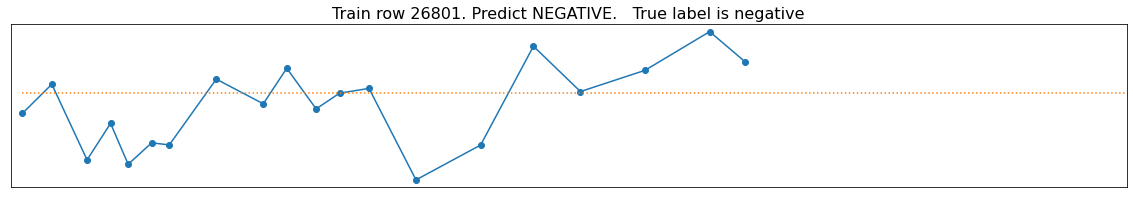

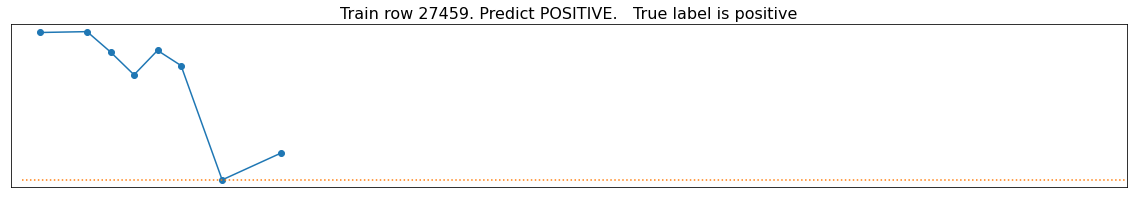

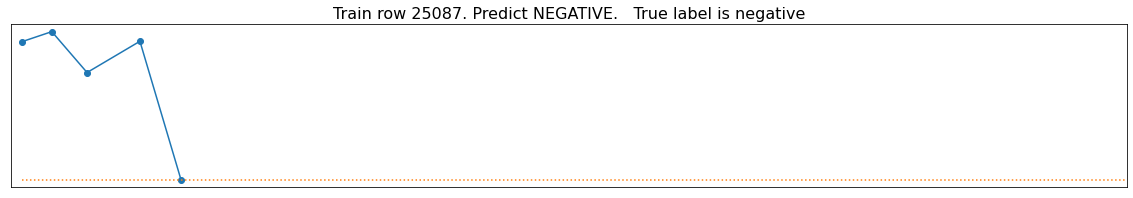

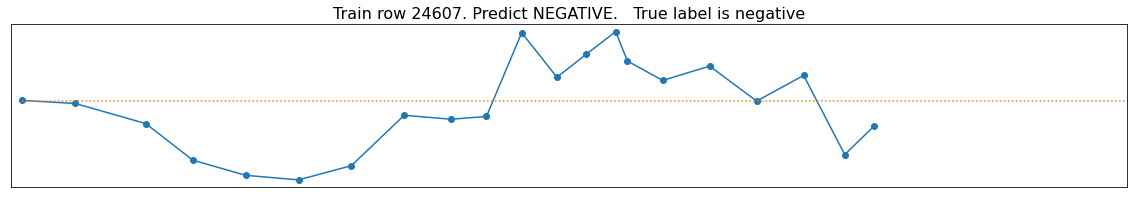

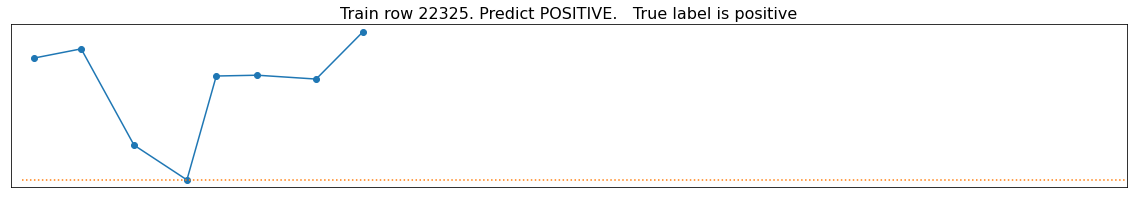

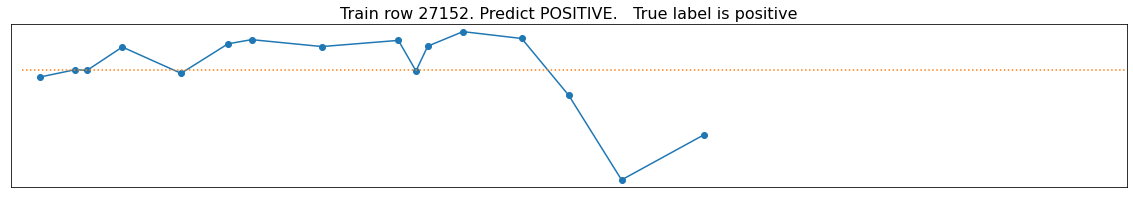

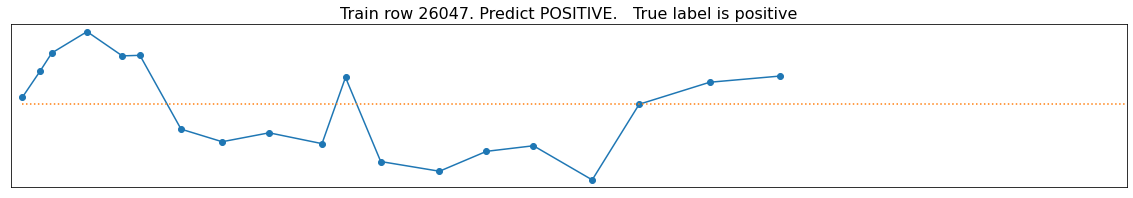

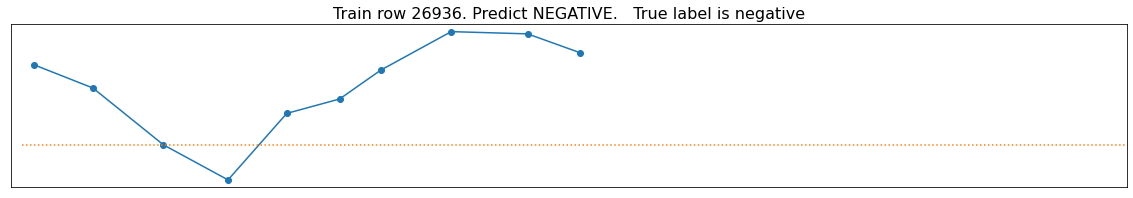

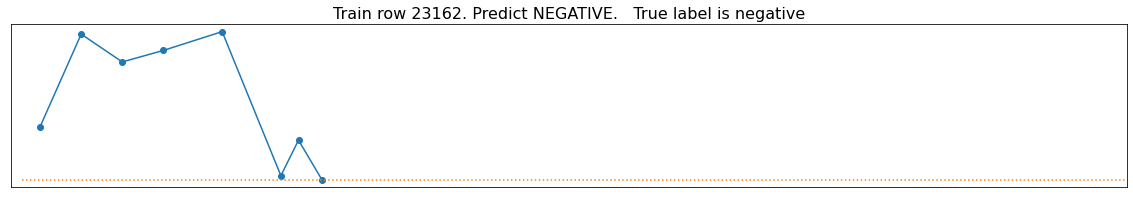

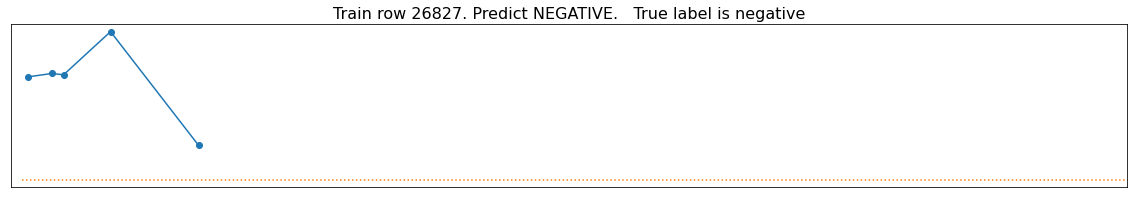

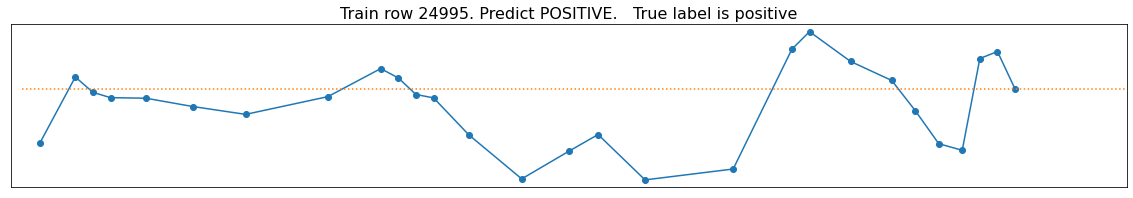

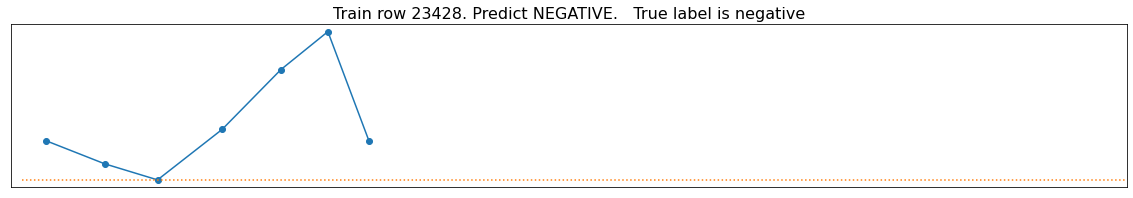

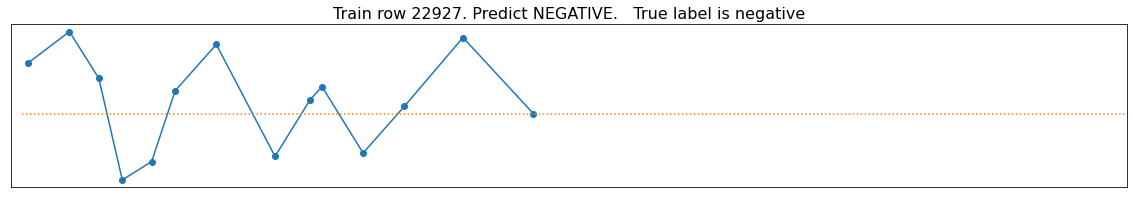

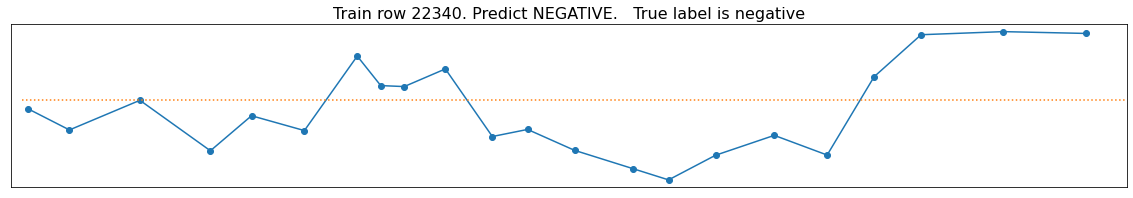

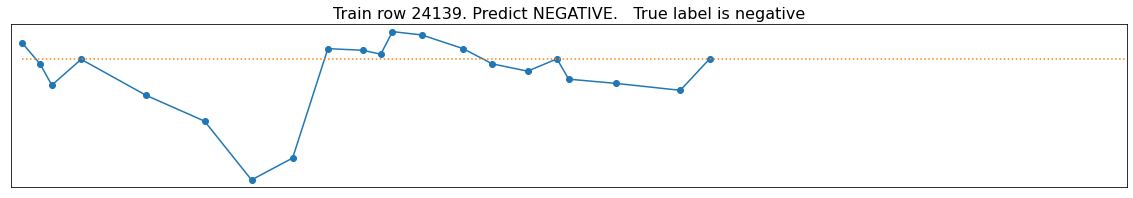

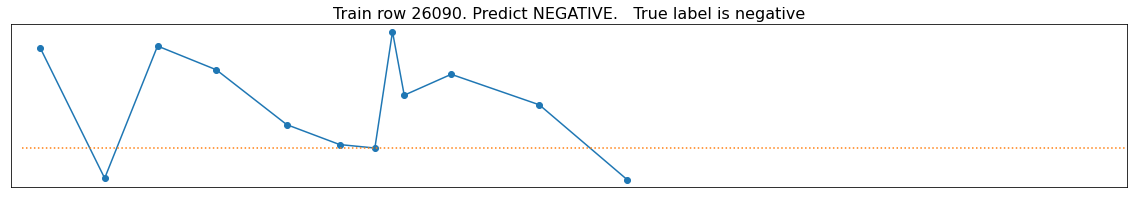

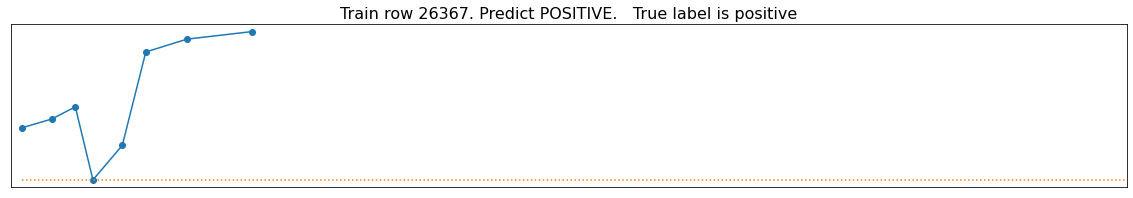

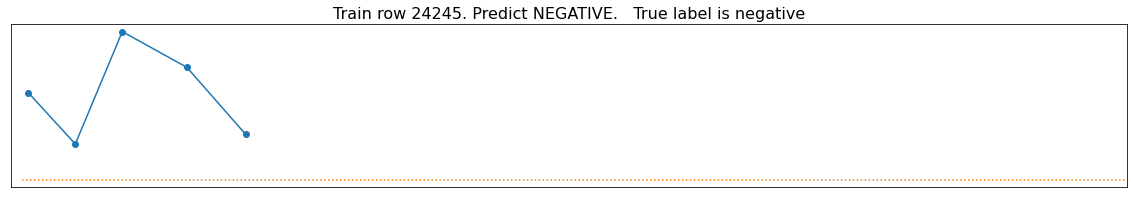

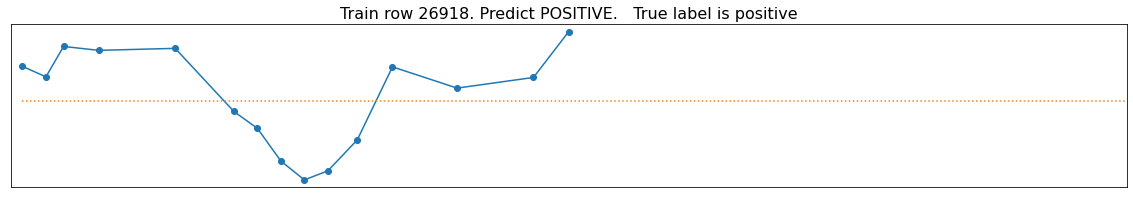

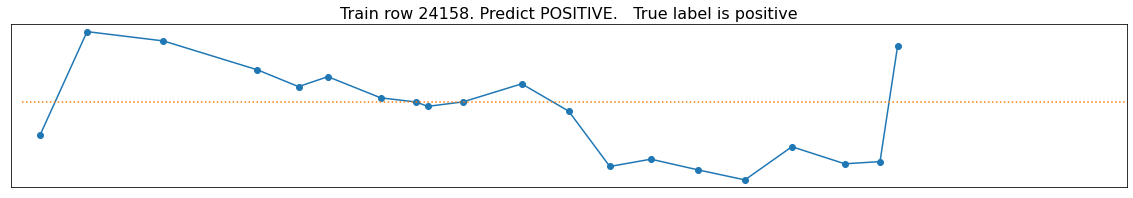

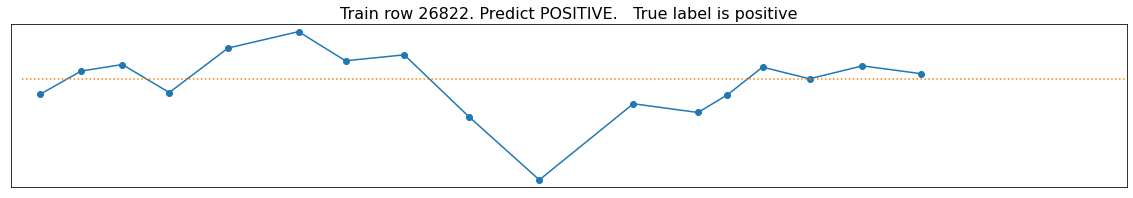

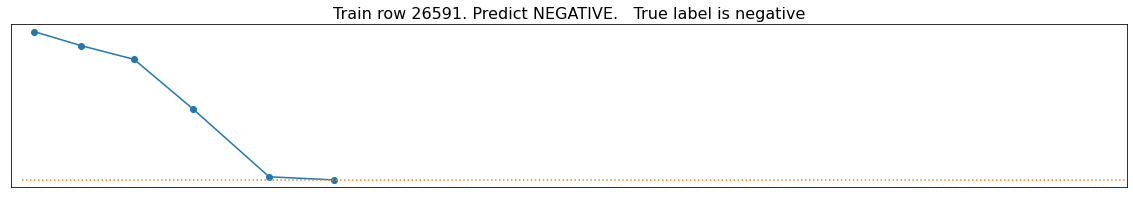

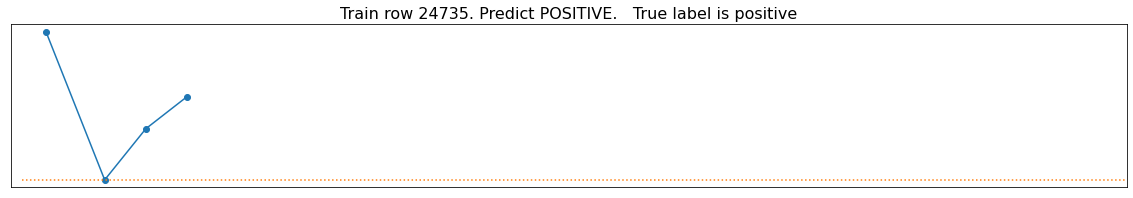

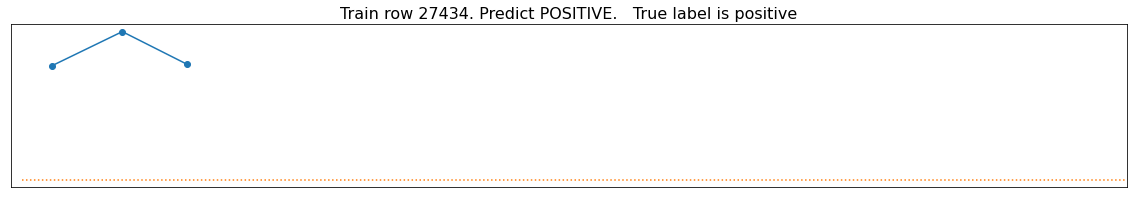

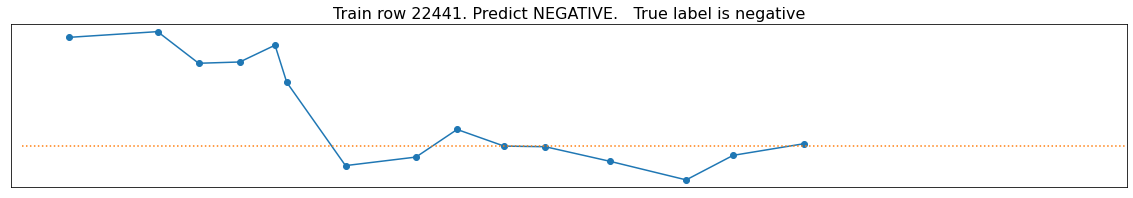

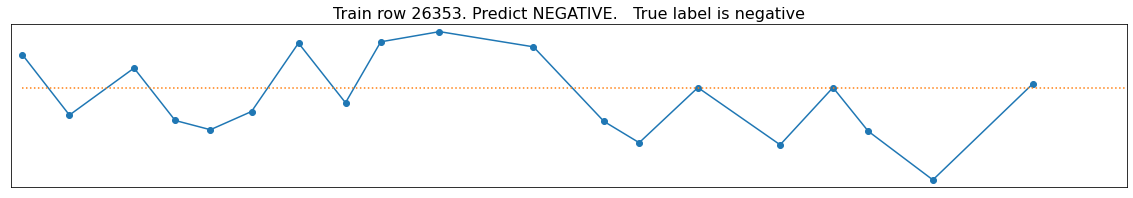

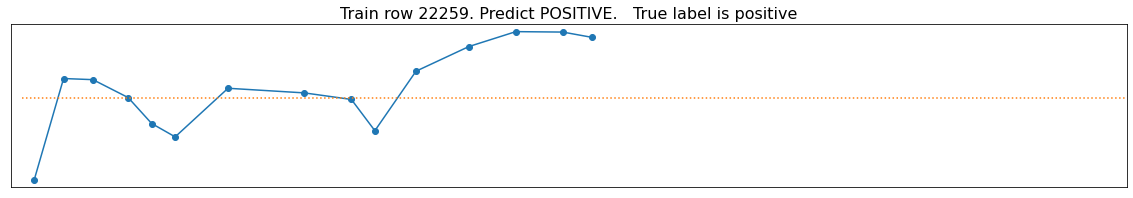

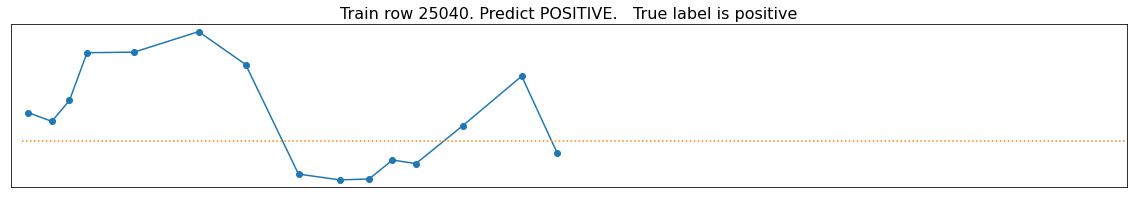

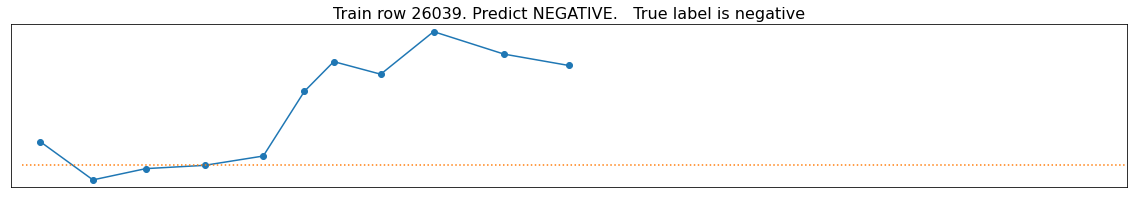

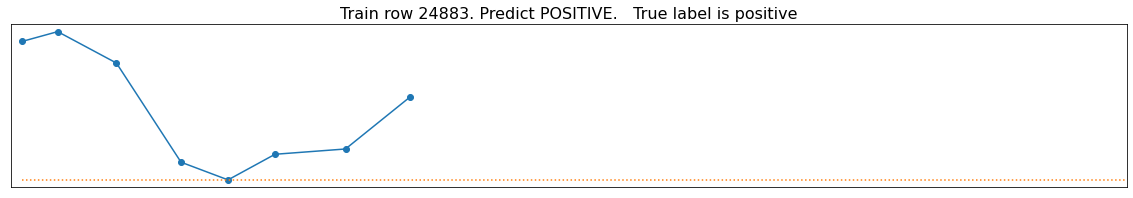

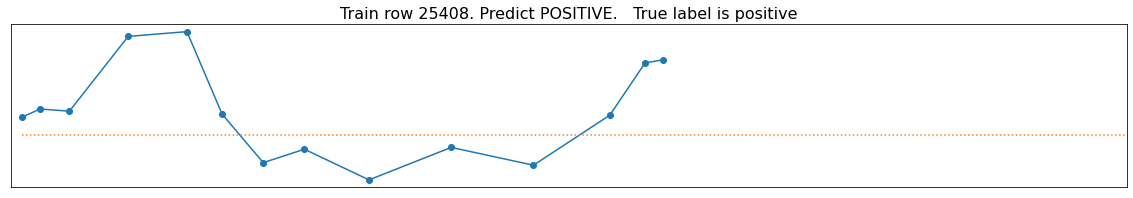

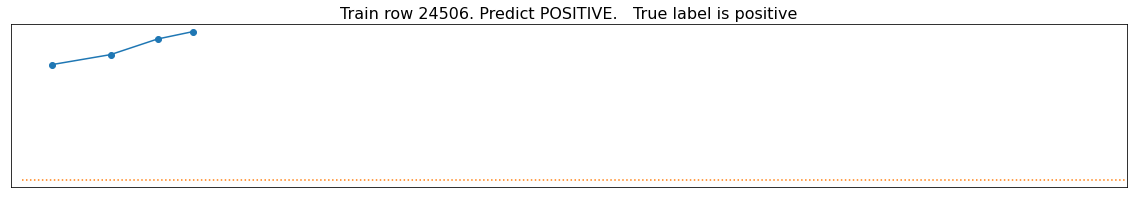

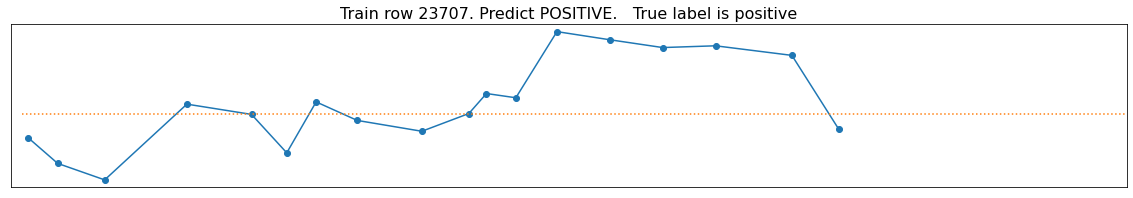

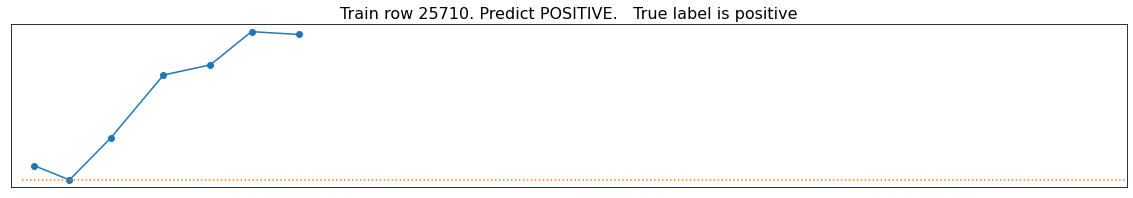

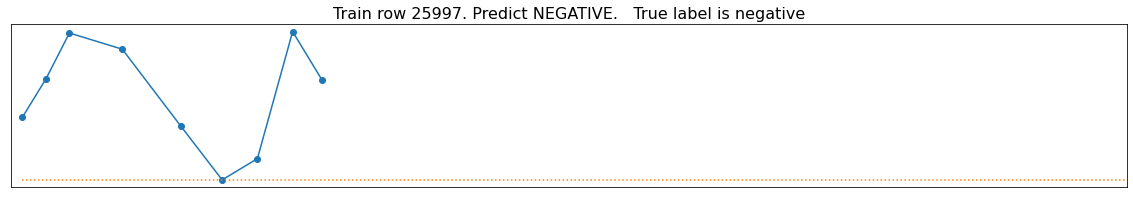

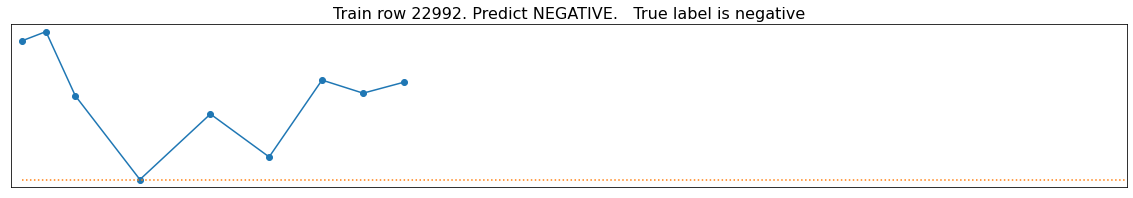

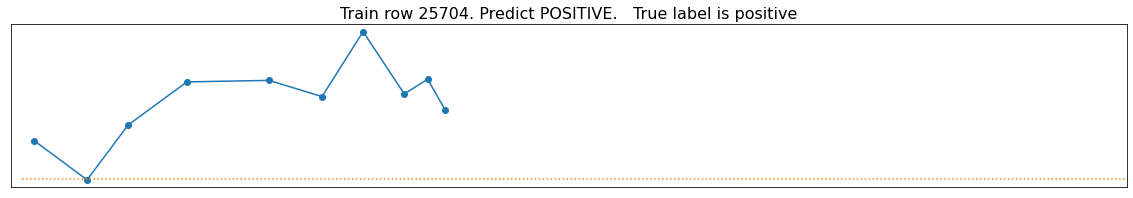

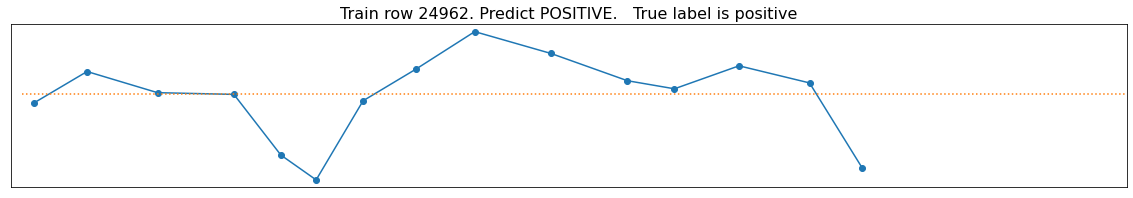

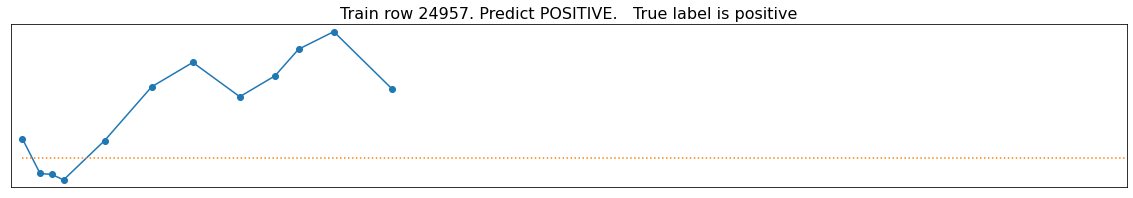

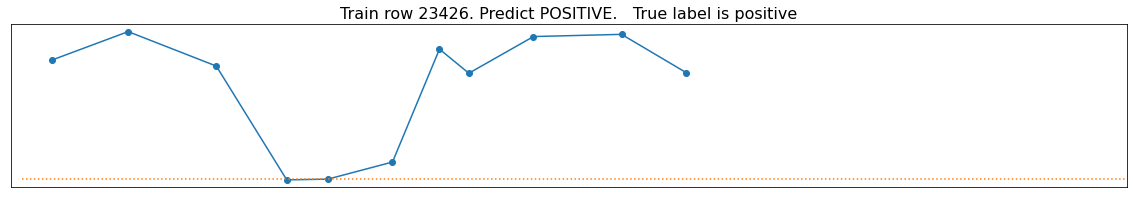

In [9]:
for kk in range(100):
    k = np.random.choice( np.arange(4*train.shape[0]//5,train.shape[0]))
    if train.loc[k,'sentiment']=='neutral': continue #boring
    if len(train.loc[k,'text'])>95: continue #too wide for display
    
    # EXTRACT INFLUENCIAL TEXT
    last_conv_output,_, pred_vec = cam_model.predict([ids[k:k+1,:],att[k:k+1,:],tok[k:k+1,:]])
    last_conv_output = np.squeeze(last_conv_output)
    pred = np.argmax(pred_vec)
    layer_weights = all_layer_weights[:, pred]
    final_output = np.dot(last_conv_output, layer_weights)
    if pr[pred]!=train.loc[k,'sentiment'].upper(): continue #skip misclassified
    
    # PLOT INFLUENCE VALUE
    print()
    plt.figure(figsize=(20,3))
    idx = np.sum(att[k,])
    v = np.argsort(final_output[:idx-1])
    mx = final_output[v[-1]]; x = max(-10,-len(v))
    mn = final_output[v[x]]
    plt.plot(cha[k,:idx-2],final_output[1:idx-1],'o-')
    plt.plot([1,95],[mn,mn],':')
    plt.xlim((0,95))
    plt.yticks([]); plt.xticks([])
    plt.title('Train row %i. Predict %s.   True label is %s'%(k,pr[pred],train.loc[k,'sentiment']),size=16)
    plt.show()
    
    # DISPLAY ACTIVATION TEXT
    html = ''
    for j in range(1,idx):
        x = (final_output[j]-mn)/(mx-mn)
        html += "<span style='background:{};font-family:monospace'>".format('rgba(255,255,0,%f)'%x)
        html += tokenizer.decode( [ids[k,j]] )
        html += "</span>"
    html += " (predict)"
    display(HTML(html))

    # DISPLAY TRUE SELECTED TEXT
    text1 = " ".join(train.loc[k,'text'].lower().split()) 
    text2 = " ".join(train.loc[k,'selected_text'].lower().split())
    sp = text1.split(text2)
    html = "<span style='font-family:monospace'>"+sp[0]+"</span>"
    for j in range(1,len(sp)):
        html += "<span style='background:yellow;font-family:monospace'>"+text2+'</span>'
        html += "<span style='font-family:monospace'>"+sp[j]+"</span>"
    html += " (true)"
    display(HTML(html))
    print()